# Training a Brain Dynamics Model

@[Chaoming Wang](https://github.com/chaoming0625)

In recent years, we saw the revolution that training a dynamical system from data or tasks has provided important insights to understand brain functions. To support this, BrainPy provides various interfaces to help users train dynamical systems.

In [1]:
import brainpy as bp
import brainpy.math as bm
import brainpy_datasets as bd

bm.enable_x64()

# bm.set_platform('cpu')

In [2]:
bp.__version__

'2.3.1'

In [3]:
import matplotlib.pyplot as plt

## Training a reservoir network model

For an echo state network, we have three components: an input node ("I"), a reservoir node ("R") for dimension expansion, and an output node ("O") for linear readout.

(Gauthier, et. al., Nature Communications, 2021) has proposed a next generation reservoir computing (NG-RC) model by using nonlinear vector autoregression (NVAR).

The difference between the two models is illustrated in the following figure.

![](../_static/NG-RC-vs-Traditional-RC.png)

<p align="center"> <b>(A)</b> A traditional RC processes time-series data using an artificial recurrent neural network. <b>(B)</b> The NG-RC performs a forecast using a linear weight of time-delay states of the time series data and nonlinear functionals of this data.</p>

Here, let's implement a next generation reservoir model to predict the chaotic time series, named as Lorenz attractor. Particularly, we expect the network has the ability to predict $P(t+l)$ from $P(t)$, where $l$ is the length of the prediction ahead.

In [4]:
dt = 0.01
data = bd.chaos.LorenzEq(100, dt=dt)

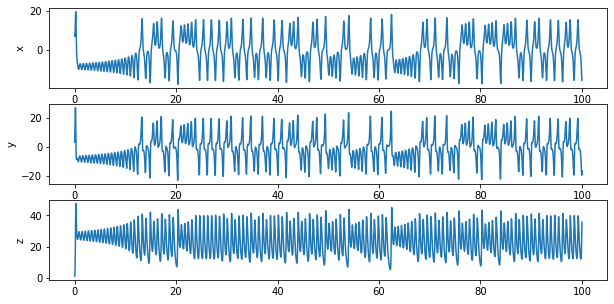

In [5]:
plt.figure(figsize=(10, 5))
plt.subplot(311)
plt.plot(bm.as_numpy(data.ts), bm.as_numpy(data.xs.flatten()))
plt.ylabel('x')
plt.subplot(312)
plt.plot(bm.as_numpy(data.ts), bm.as_numpy(data.ys.flatten()))
plt.ylabel('y')
plt.subplot(313)
plt.plot(bm.as_numpy(data.ts), bm.as_numpy(data.zs.flatten()))
plt.ylabel('z')
plt.show()

Let's first create a function to get the data.

In [6]:
def get_subset(data, start, end):
    res = {'x': data.xs[start: end],
           'y': data.ys[start: end],
           'z': data.zs[start: end]}
    res = bm.hstack([res['x'], res['y'], res['z']])
    return res.reshape((1, ) + res.shape)


To accomplish this task, we implement a next-generation reservoir model of 4 delay history information with stride of 5, and their quadratic polynomial monomials, same as (Gauthier, et. al., Nature Communications, 2021).

In [7]:
class NGRC(bp.DynamicalSystem):
  def __init__(self, num_in, num_out):
    super(NGRC, self).__init__()
    self.r = bp.layers.NVAR(num_in, delay=4, order=2, stride=5)
    self.o = bp.layers.Dense(self.r.num_out, num_out, mode=bm.training_mode)

  def update(self, sha, x):
    # "sha" is the arguments shared across all nodes.
    # other arguments like "x" can be customized by users.
    return self.o(sha, self.r(sha, x))

In [8]:
with bm.environment(bm.batching_mode):
    model = NGRC(num_in=3, num_out=3)

Moreover, we use Ridge Regression method to train the model.

In [9]:
trainer = bp.train.RidgeTrainer(model, alpha=1e-6)

We warm-up the network with 20 ms.

In [10]:
warmup_data = get_subset(data, 0, int(20/dt))

outs = trainer.predict(warmup_data)

# outputs should be an array with the shape of
# (num_batch, num_time, num_out)
outs.shape

  0%|          | 0/2000 [00:00<?, ?it/s]

(1, 2000, 3)

The training data is the time series from 20 ms to 80 ms. We want the network has the ability to forecast 1 time step ahead.

In [11]:
x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+1, int(80/dt)+1)

_ = trainer.fit([x_train, y_train])

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Then we test the trained network with the next 20 ms.

In [12]:
x_test = get_subset(data, int(80/dt), int(100/dt)-1)
y_test = get_subset(data, int(80/dt) + 1, int(100/dt))

predictions = trainer.predict(x_test)

bp.losses.mean_squared_error(y_test, predictions)

  0%|          | 0/1999 [00:00<?, ?it/s]

Array(3.62923347e-09, dtype=float64)

In [13]:
def plot_difference(truths, predictions):
    truths = bm.as_numpy(truths)
    predictions = bm.as_numpy(predictions)

    plt.subplot(311)
    plt.plot(truths[0, :, 0], label='Ground Truth')
    plt.plot(predictions[0, :, 0], label='Prediction')
    plt.ylabel('x')
    plt.legend()
    plt.subplot(312)
    plt.plot(truths[0, :, 1], label='Ground Truth')
    plt.plot(predictions[0, :, 1], label='Prediction')
    plt.ylabel('y')
    plt.legend()
    plt.subplot(313)
    plt.plot(truths[0, :, 2], label='Ground Truth')
    plt.plot(predictions[0, :, 2], label='Prediction')
    plt.ylabel('z')
    plt.legend()
    plt.show()

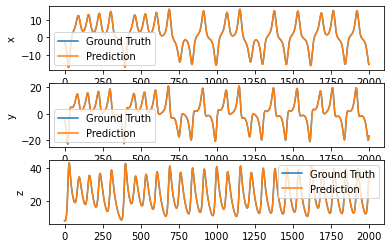

In [14]:
plot_difference(y_test, predictions)

We can make the task harder to forecast 10 time step ahead.

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1990 [00:00<?, ?it/s]

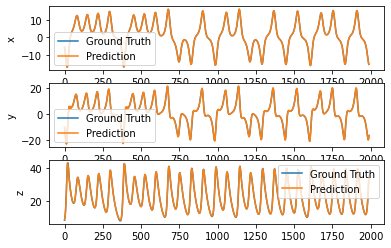

In [15]:
warmup_data = get_subset(data, 0, int(20/dt))
outs = trainer.predict(warmup_data)

x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+10, int(80/dt)+10)
trainer.fit([x_train, y_train])

x_test = get_subset(data, int(80/dt), int(100/dt)-10)
y_test = get_subset(data, int(80/dt) + 10, int(100/dt))
predictions = trainer.predict(x_test)

plot_difference(y_test, predictions)

Or forecast 100 time step ahead.

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1900 [00:00<?, ?it/s]

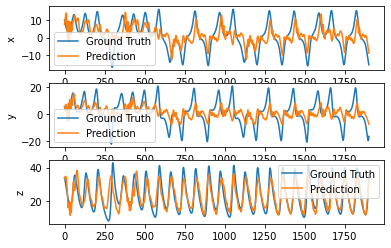

In [16]:
warmup_data = get_subset(data, 0, int(20/dt))
_ = trainer.predict(warmup_data)

x_train = get_subset(data, int(20/dt), int(80/dt))
y_train = get_subset(data, int(20/dt)+100, int(80/dt)+100)
trainer.fit([x_train, y_train])

x_test = get_subset(data, int(80/dt), int(100/dt)-100)
y_test = get_subset(data, int(80/dt) + 100, int(100/dt))
predictions = trainer.predict(x_test)

plot_difference(y_test, predictions)

As you see, forecasting larger time step makes the learning more difficult.

## Training an artificial recurrent network

In recent years, artificial recurrent neural networks trained with back propagation through time (BPTT) have been a useful tool to study the network mechanism of brain functions. To support training networks with BPTT, BrainPy provides ``brainpy.train.BPTT`` interface.

Here, we demonstrate how to train an artificial recurrent neural network by using a white noise integration task. In this task, we want our trained RNN model has the ability to integrate white noise. For example, if we have a time series of noise data,

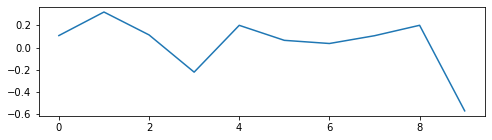

In [17]:
noises = bm.random.normal(0, 0.2, size=10)

plt.figure(figsize=(8, 2))
plt.plot(noises.to_numpy().flatten())
plt.show()

Now, we want to get a model which can integrate the noise ``bm.cumsum(noises) * dt``: 

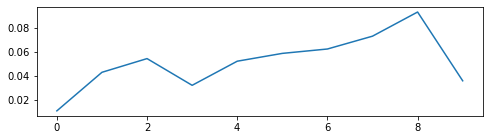

In [18]:
dt = 0.1
integrals = bm.cumsum(noises) * dt

plt.figure(figsize=(8, 2))
plt.plot(integrals.to_numpy().flatten())
plt.show()

Here, we first define a task which generates the input data and the target integration results. 

In [25]:
from functools import partial

dt = 0.04
num_step = int(1.0 / dt)
num_batch = 128


@bm.jit
@bm.to_object(dyn_vars=bm.random.DEFAULT)
def build_inputs_and_targets(mean=0.025, scale=0.01):
  # Create the white noise input
  sample = bm.random.normal(size=(num_batch, 1, 1))
  bias = mean * 2.0 * (sample - 0.5)
  samples = bm.random.normal(size=(num_batch, num_step, 1))
  noise_t = scale / dt ** 0.5 * samples
  inputs = bias + noise_t
  targets = bm.cumsum(inputs, axis=1)
  return inputs, targets


def train_data():
  for _ in range(100):
    yield build_inputs_and_targets()

Then, we create and initialize the model. Note here we need the model train its initial state, so we need set ``state_trainable=True`` for the used `VanillaRNN` instance. 

In [20]:
class RNN(bp.DynamicalSystem):
  def __init__(self, num_in, num_hidden):
    super(RNN, self).__init__()
    self.rnn = bp.layers.RNNCell(num_in, num_hidden, train_state=True)
    self.out = bp.layers.Dense(num_hidden, 1)

  def update(self, sha, x):
    # "sha" is the arguments shared across all nodes.
    return self.out(sha, self.rnn(sha, x))


with bm.training_environment():
    model = RNN(1, 100)

``brainpy.nn.BPTT`` trainer receives a ``loss`` function setting, and an ``optimizer`` setting. Loss function can be selected from the ``brainpy.losses`` module, or it can be a callable function receives `(predictions, targets)` argument. Optimizer setting must be an instance of ``brainpy.optim.Optimizer``. 

Here we define a loss function which use Mean Squared Error (MSE) to measure the error between the targets and the predictions. We also apply a L2 regularization. 

In [21]:
# define loss function
def loss(predictions, targets, l2_reg=2e-4):
    mse = bp.losses.mean_squared_error(predictions, targets)
    l2 = l2_reg * bp.losses.l2_norm(model.train_vars().unique().dict()) ** 2
    return mse + l2

In [22]:
# define optimizer
lr = bp.optim.ExponentialDecay(lr=0.025, decay_steps=1, decay_rate=0.99975)
opt = bp.optim.Adam(lr=lr, eps=1e-1)

In [23]:
# create a trainer
trainer = bp.train.BPTT(model,
                        loss_fun=loss,
                        optimizer=opt)

In [26]:
# train the model
trainer.fit(train_data, num_epoch=30)

Train 0 epoch, use 2.2705 s, loss 0.5431804598636681
Train 1 epoch, use 1.1520 s, loss 0.1111436345136279
Train 2 epoch, use 1.0568 s, loss 0.028502398640104478
Train 3 epoch, use 1.0550 s, loss 0.021557415636524625
Train 4 epoch, use 1.2334 s, loss 0.02103036084318231
Train 5 epoch, use 1.0782 s, loss 0.03621808481894387
Train 6 epoch, use 1.2978 s, loss 0.020830462560546617
Train 7 epoch, use 1.1253 s, loss 0.020349677236923852
Train 8 epoch, use 1.0884 s, loss 0.01999626884753028
Train 9 epoch, use 1.0844 s, loss 0.019711449539100128
Train 10 epoch, use 1.0470 s, loss 0.01948684809571936
Train 11 epoch, use 1.0619 s, loss 0.019206390127710953
Train 12 epoch, use 1.0470 s, loss 0.018981963159608338
Train 13 epoch, use 1.0411 s, loss 0.01878478481278808
Train 14 epoch, use 1.0648 s, loss 0.018614482841389626
Train 15 epoch, use 1.0385 s, loss 0.01834170918632372
Train 16 epoch, use 1.0266 s, loss 0.0329911761349229
Train 17 epoch, use 1.0184 s, loss 0.019153171678052538
Train 18 epoch

The training losses can be retrieved by `.get_hist_metric()` function. 

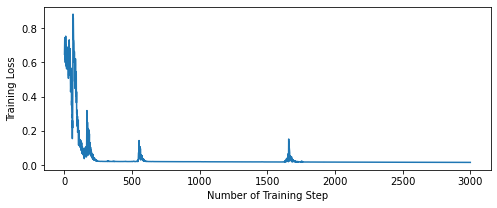

In [27]:
plt.figure(figsize=(8, 3))
plt.plot(trainer.get_hist_metric(metric='loss'))
plt.xlabel('Number of Training Step')
plt.ylabel('Training Loss')
plt.show()

Finally, let's try the trained network, and test whether it can generate the correct integration results.

In [29]:
model.reset_state(num_batch)
x, y = build_inputs_and_targets()
predicts = trainer.predict(x)

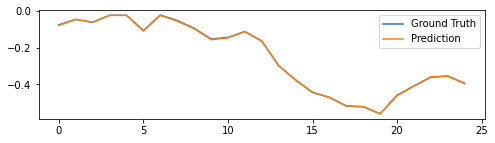

In [30]:
plt.figure(figsize=(8, 2))
plt.plot(bm.as_numpy(y[0]).flatten(), label='Ground Truth')
plt.plot(bm.as_numpy(predicts[0]).flatten(), label='Prediction')
plt.legend()
plt.show()

## Training a spiking neural network

BrainPy also supports to train spiking neural networks.

In the following, we demonstrate how to use back-propagation algorithms to train spiking neurons with a simple example.

Our model is a simple three layer model:

- an input layer
- a LIF layer
- a readout layer

The synaptic connection between each layer is the Exponenetial synapse model.

In [31]:
class SNN(bp.Network):
  def __init__(self, num_in, num_rec, num_out):
    super(SNN, self).__init__()

    # parameters
    self.num_in = num_in
    self.num_rec = num_rec
    self.num_out = num_out

    # neuron groups
    self.i = bp.neurons.InputGroup(num_in, mode=bp.modes.training)
    self.r = bp.neurons.LIF(num_rec, tau=10, V_reset=0, V_rest=0, V_th=1., mode=bp.modes.training)
    self.o = bp.neurons.LeakyIntegrator(num_out, tau=5, mode=bp.modes.training)

    # synapse: i->r
    self.i2r = bp.synapses.Exponential(self.i, self.r, bp.conn.All2All(), tau=10.,
                                       output=bp.synouts.CUBA(target_var=None),
                                       g_max=bp.init.KaimingNormal(scale=20.),
                                       mode=bp.modes.training)
    # synapse: r->o
    self.r2o = bp.synapses.Exponential(self.r, self.o, bp.conn.All2All(), tau=10.,
                                       output=bp.synouts.CUBA(target_var=None),
                                       g_max=bp.init.KaimingNormal(scale=20.),
                                       mode=bp.modes.training)

    # whole model
    self.model = bp.Sequential(self.i, self.i2r, self.r, self.r2o, self.o)

  def update(self, tdi, spike):
    self.model(tdi, spike)
    return self.o.V.value

In [33]:
with bm.training_environment():
    net = SNN(100, 10, 2)  # out task is a two label classification task

We try to use this simple task to classify a random spiking data into two classes.

In [35]:
num_step = 2000
num_sample = 256
freq = 5  # Hz
mask = bm.random.rand(num_sample, num_step, net.num_in)
x_data = bm.zeros((num_sample, num_step, net.num_in))
x_data[mask < freq * bm.get_dt() / 1000.] = 1.0
y_data = bm.asarray(bm.random.rand(num_sample) < 0.5, dtype=bm.float_)

def get_data():
    for _ in range(1):
        yield x_data, y_data

Same as the training of artificial recurrent neural networks, we use Adam optimizer and cross entropy loss to train the model.

In [36]:
opt = bp.optim.Adam(lr=2e-3)

def loss(predicts, targets):
  return bp.losses.cross_entropy_loss(bm.max(predicts, axis=1), targets)


trainer = bp.train.BPTT(net,
                        loss_fun=loss,
                        optimizer=opt)

In [37]:
trainer.fit(train_data=get_data,
            num_report=10,
            num_epoch=200)

Train 10 steps, use 0.9103 s, loss 0.7219832174729163
Train 20 steps, use 0.7449 s, loss 0.6696123267371417
Train 30 steps, use 0.6464 s, loss 0.6491206328569219
Train 40 steps, use 0.5883 s, loss 0.6156547140069775
Train 50 steps, use 0.5729 s, loss 0.5987596785982736
Train 60 steps, use 0.6343 s, loss 0.5862205241316523
Train 70 steps, use 0.7598 s, loss 0.5607236263572535
Train 80 steps, use 0.6077 s, loss 0.5457860326436039
Train 90 steps, use 0.5707 s, loss 0.5264014105800172
Train 100 steps, use 0.5862 s, loss 0.5146514133005329
Train 110 steps, use 0.5722 s, loss 0.5068201255745326
Train 120 steps, use 0.5812 s, loss 0.4896138875231886
Train 130 steps, use 0.5887 s, loss 0.4799118492626251
Train 140 steps, use 0.5656 s, loss 0.47088261120558417
Train 150 steps, use 0.5742 s, loss 0.44685486258925866
Train 160 steps, use 0.5626 s, loss 0.43019316163725896
Train 170 steps, use 0.5736 s, loss 0.4131096257548337
Train 180 steps, use 0.5706 s, loss 0.4043105738199416
Train 190 steps,

The training loss is continuously decreasing, demonstrating that the network is effectively training.

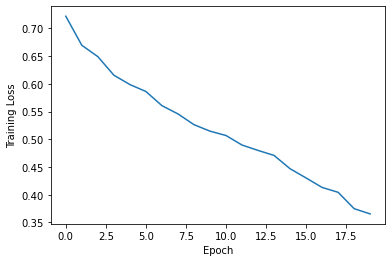

In [38]:
# visualize the training losses
plt.plot(trainer.get_hist_metric())
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.show()

Let's visualize the trained spiking neurons.

In [39]:
import numpy as np
from matplotlib.gridspec import GridSpec

def plot_voltage_traces(mem, spk=None, dim=(3, 5), spike_height=5):
  plt.figure(figsize=(15, 8))
  gs = GridSpec(*dim)
  mem = 1. * mem
  if spk is not None:
    mem[spk > 0.0] = spike_height
  mem = bm.as_numpy(mem)
  for i in range(np.prod(dim)):
    if i == 0:
      a0 = ax = plt.subplot(gs[i])
    else:
      ax = plt.subplot(gs[i], sharey=a0)
    ax.plot(mem[i])
  plt.tight_layout()
  plt.show()

  0%|          | 0/2000 [00:00<?, ?it/s]

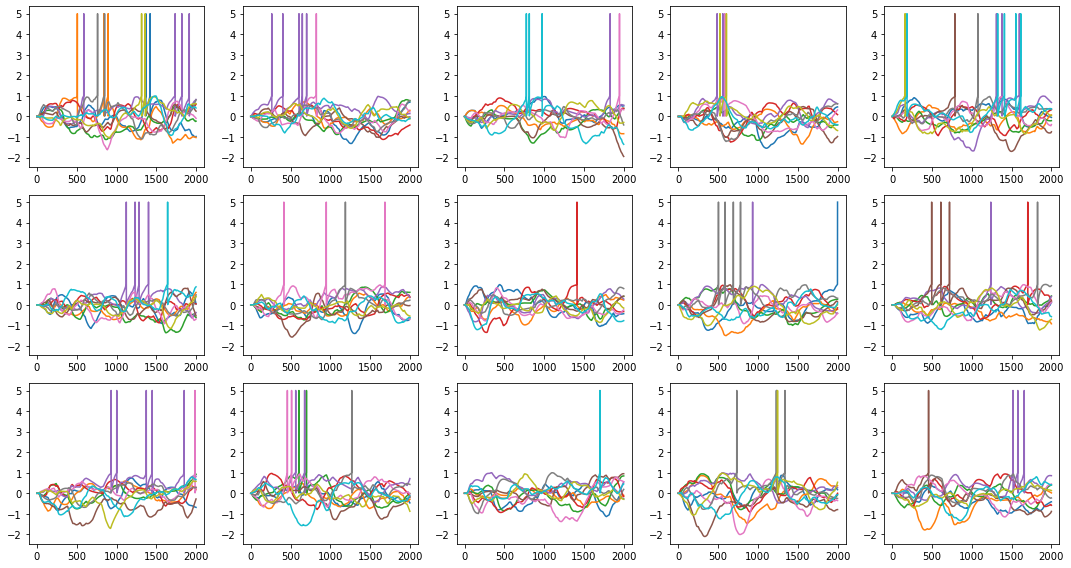

In [41]:
# get the prediction results and neural activity

runner = bp.DSRunner(
    net, monitors={'r.spike': net.r.spike, 'r.membrane': net.r.V}
)
out = runner.run(inputs=x_data, reset_state=True)
plot_voltage_traces(runner.mon.get('r.membrane'), runner.mon.get('r.spike'))

In [42]:
# the prediction accuracy

m = bm.max(out, axis=1)  # max over time
am = bm.argmax(m, axis=1)  # argmax over output units
acc = bm.mean(y_data == am)  # compare to labels
print("Accuracy %.3f" % acc)

Accuracy 0.910
